# Convex-relaxed Neural Network Robustness Verification Demo
This notebook demonstrates the different robustness verification methods (MILP, LP-ALL, LP-LAST, and LP-GREEDY), used in our paper [A Convex Relaxation Barrier to Tight Robustness Verfication of Neural Networks](https://arxiv.org/abs/1902.08722), on a toy example. LP-Greedy is the dual network method of [Wong and Kolter](https://github.com/locuslab/convex_adversarial).

In all the below experiments, we find the margins of each network given a data point and a maximum allowed perturbation. Here, the margins are defined as the difference between the logits corresponding to the predicted label and every other label, respectively. The network is certified to be robust around data point X if all the margins are positive.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from wong_kolter.version0point2 import Affine, full_bias
from wong_kolter import DualNetBounds as DualNetBounds

#import gurobipy
import cvxpy as cp

#### Setup


In [2]:
## The maximum allowed l_infinity perturbation of the input.
epsilon = 0.5
############################################

torch.manual_seed(1)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Load dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)
for X,y in test_loader:
    break

sample = X.flatten().numpy() # The sample that we want to verify the network around

### A toy randomly initialized neural network
input_dim = sample.shape[0]
num_classes = 10

net = nn.Sequential(
    Flatten(),
    nn.Linear(input_dim,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,num_classes)
)

logits = net(X)
y_pred = logits.max(1)[1]
print('The predicted class is "{}". We want to check if within a maximum l_infinity perturbation of {}, this predicted label changes. \
If this is the case, the network is NOT robust around this data point. Otherwise, the network is robust.'.format(y_pred.item(), epsilon))

The predicted class is "7". We want to check if within a maximum l_infinity perturbation of 0.5, this predicted label changes. If this is the case, the network is NOT robust around this data point. Otherwise, the network is robust.


## LP-GREEDY
This is the dual LP formulation of [Wong and Kolter 2018](https://arxiv.org/abs/1711.00851). 

Robustness NOT certified for epsilon=0.5 using LP-GREEDY


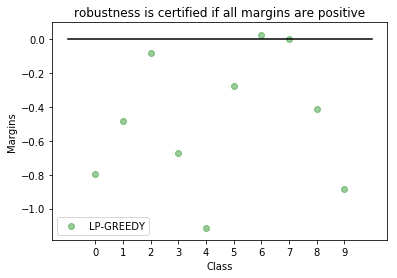

In [3]:
dual_net = DualNetBounds(net, X, epsilon, bounded_input=True)
C = torch.eye(num_classes).type_as(X)[y_pred].unsqueeze(1) - torch.eye(num_classes).type_as(X).unsqueeze(0)
margins_lp_greedy = dual_net(C).data

margins_lp_greedy = margins_lp_greedy.flatten().data.numpy()

plt.scatter([i for i in range(num_classes)],margins_lp_greedy, label='LP-GREEDY', color='g', alpha=0.4)
plt.plot([-1,num_classes],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_greedy)>=0):
    print('Robustness certified for epsilon={} using LP-GREEDY'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-GREEDY'.format(epsilon))

## LP-LAST
This is the same as LP-GREEDY, but solves the exact primal LP on the last layer of the neural network, instead of solving the dual heuristically. The preactivation bounds on the internal neurons of the network are the ones used by LP-GREEDY. Therefore, LP-LAST is expected to be slightly tighter than LP-GREEDY.

#### Helper functions

In [4]:
def get_linearLayers_net(W, b):
    layers_list = [[nn.Linear(ww.shape[1],ww.shape[0]), nn.ReLU()] for ww in W]
    flat_layers_list = [item for sublist in layers_list for item in sublist]
    net = nn.Sequential(Flatten(),
                       *flat_layers_list[:-1]
                       )
    # Load weights
    i = 0
    for idx,l in enumerate(net):
        if isinstance(l, nn.Linear):
            l.weight.data = torch.Tensor(W[i])
            l.bias.data = torch.Tensor(b[i])
            i += 1
    return net


def init_affine(net, X):
    layers = [l for l in net if isinstance(l, (nn.Linear, nn.Conv2d))]
    affine = [Affine(l) for l in layers]

    _ = X.view(1,-1)
    for a in affine: 
        _ = a(_)

    biases = [full_bias(l, affine[i].out_features) 
                    for i,l in enumerate(layers)]
    return affine, biases

In [5]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

# Get the weights and biases from the network. Will be used in the LP formulation later. 
W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

# Popoulate the preactivation bounds of all layers except the last layer.
zl = []
zu = []
for idx, (ww,bb) in enumerate(zip(W,b), start=1):
    dual_net = DualNetBounds(get_linearLayers_net(W[:idx], b[:idx]), X, epsilon, bounded_input=True)
    CC = torch.eye(ww.shape[0]).type_as(X).unsqueeze(0)
    zl.append(dual_net(CC).data.squeeze(0))
    CC = -torch.eye(ww.shape[0]).type_as(X).unsqueeze(0)
    zu.append(-dual_net(CC).data.squeeze(0))

# This LP formulation can be found in Appendix A.1 of Wong and Kolter 2018 (https://arxiv.org/abs/1711.00851).
# The implementation is modified from (https://github.com/locuslab/convex_adversarial)
z = [cp.Variable(l.in_features) for l in affine]
zhat = [cp.Variable(l.out_features) for l in affine]

# Constraints of the LP
cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(num_linear_layers)]
cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
               cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
               zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(num_linear_layers-1)]

cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

# For each neuron in the last layer, solve an LP to find the margin.
margins_lp_last = []
for node_idx in range(zu[-1].shape[0]):
    f_primal = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
    margins_lp_last.append(f_primal)

Robustness NOT certified for epsilon=0.5 using LP-LAST


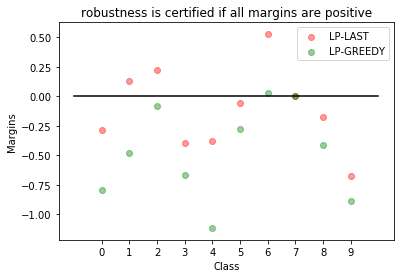

In [6]:
plt.scatter([i for i in range(10)],margins_lp_last, label='LP-LAST',color='r', alpha=0.4)
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')

plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_last)>=0):
    print('Robustness certified for epsilon={} using LP-LAST'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-LAST'.format(epsilon))

# LP-ALL
This is the layer-wise optimal convex relaxation formulation that is defined in Section 5.1 of [our paper](https://arxiv.org/abs/1902.08722). LP-ALL is tighter than both LP-LAST and LP-GREEDY.

In [7]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

# Get the weights and biases from the network. Will be used in the LP formulation later. 
W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]

for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in layer {0} is {1}'.format(k, affine[k].out_features))
    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

    # Constraints of the LP
    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
    cons_zero = [z[i] >= 0 for i in range(1,k+1)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                    cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                    zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

    margins_lp_all = []
    for node_idx in range(affine[k].out_features):
        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins_lp_all.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
            margins_lp_all.append(f_primal_1)
        else:
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
            f_min = zhat[-1][node_idx].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
            f_max = zhat[-1][node_idx].value
            zu[k].append(f_max)
    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])


Layer:  0
Number of nodes in layer 0 is 4
Layer:  1
Number of nodes in layer 1 is 4
Layer:  2
Number of nodes in layer 2 is 10


Robustness NOT certified for epsilon=0.5 using LP-ALL


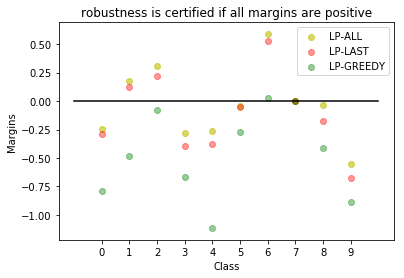

In [8]:
plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_all)>=0):
    print('Robustness certified for epsilon={} using LP-ALL'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-ALL'.format(epsilon))

# MILP
This is a simple implementation of the MILP formulation for ReLU networks of the [Tjeng et. al., 2019](https://arxiv.org/abs/1711.07356). MILP solves the verification problem exactly, there fore is tighter than the above algorithms.

In [9]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

margins_milp = []
z = [cp.Variable(l.in_features) for l in affine[:num_linear_layers]]
zhat = [cp.Variable(l.out_features) for l in affine[:num_linear_layers]]
a = [cp.Variable(l.out_features, boolean=True) for l in affine[:num_linear_layers]]

# These MILP constraints can be found in the formulation presented 
# in Appendix A.1 of Tjeng et. al., 2019 (https://arxiv.org/abs/1711.07356)
cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(num_linear_layers)]
cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
cons_milp_1 = [z[i+1] <= cp.multiply(zu[i],a[i]) for i in range(num_linear_layers-1)]
cons_milp_2 = [z[i+1] <= zhat[i] - cp.multiply(zl[i],(1 - a[i])) for i in range(num_linear_layers-1)]

cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_milp_1 + cons_milp_2

for node_idx in range(affine[num_linear_layers-1].out_features):
    if node_idx == y_pred.item():
        margins_milp.append(0)
        continue
    f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS_BB)
    margins_milp.append(f_primal_1)

Robustness NOT certified for epsilon=0.5 using MILP


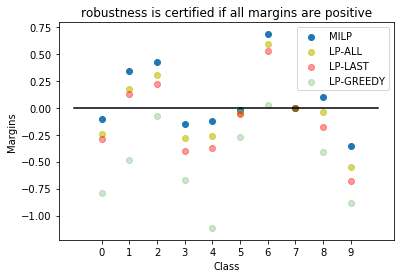

In [10]:
plt.scatter([i for i in range(10)], margins_milp, label='MILP')
plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.2, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_milp)>=0):
    print('Robustness certified for epsilon={} using MILP'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using MILP'.format(epsilon))